In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nr
from math import pi, fabs

plt.rcParams["figure.figsize"] = [14, 8]

In [3]:
def readData(filename):
    """
    Reads the data, and subtracts the minimum time value from the time array
    (I am assuming the data files are in a subfolder named 'data')
    Input:
        filename - a string
    Output:
        returns a numpy array containing the data, with the time array shifted.
        Numpy array has 3 columns - time (days), flux and flux error

    """
    data_array = np.loadtxt("data/" + filename)  # reading the file into a numpy array
    min_time = min(data_array[:, 0])

    data_array[:, 0] = data_array[:, 0] - min_time

    return data_array

In [ ]:
def plotTESS(data):
    """
    Plots the TESS light-curve (flux against time, including error bars)
    Input:
        data - time-flux-fluxerror numpy data array
    """
    plt.errorbar(
        x=data[:, 0],
        y=data[:, 1],
        yerr=data[:, 2],
        xerr=None,
        fmt="o",
        ecolor="lightsteelblue",
        elinewidth=1,
    )
    plt.xlabel("Time (days)")
    plt.ylabel("Flux")
    plt.title("TESS light-curve")
    plt.show()

    return

In [4]:
def calc_S(data, p, M):
    """
    Inputs:
        p - trial period
        M - number of phase bins
        data - time-flux-fluxerror numpy data array
    Returns:
        S

    Method:
        1. Phase fold the data, with trial period p
        2. Divide flux-phase data into M phase bins
        3. Compute A, E
        4. Compute S
    """
    mean_flux = np.mean(data[:, 1])

    # Phase folding the data at trial period p
    time = data[:, 0]
    phi = np.mod(time, p) / p

    # Dividing flux-phase data into M phase bins
    bin_mean_flux = np.zeros(M)  # array to store the mean flux of each bin
    bin_numberofpoints = np.zeros(M)  # array to store the number of points in each bin.
    bin_points_list = (
        []
    )  # list to store, for each bin, an array containing the flux values for points in that bin

    bin_width = np.max(phi) / M

    for i in range(M):
        # This if-elif-else block was needed to ensure all points were put into a bin.
        # Previously, a couple of points (at both ends) would not be binned.
        if i == 0:
            bin_points = data[(phi <= (i + 1) * bin_width)][:, 1]
        elif i == M - 1:
            bin_points = data[(i * bin_width < phi)][:, 1]
        else:
            bin_points = data[(i * bin_width < phi) & (phi <= (i + 1) * bin_width)][
                :, 1
            ]
        bin_points_list.append(bin_points)

        bin_numberofpoints[i] = len(bin_points_list[i])

        if bin_numberofpoints[i] > 0:
            bin_mean_flux[i] = np.mean(bin_points_list[i])
        else:
            bin_mean_flux[i] = 0

    # Computing A, E and S
    A = np.sum(bin_numberofpoints * np.square((bin_mean_flux - mean_flux)))
    E = 0
    for j in range(M):
        E += np.sum(np.square(bin_points_list[j] - bin_mean_flux[j]))

    N = len(time)

    S = ((N - M) * A) / ((M - 1) * E)

    return S

In [5]:
def compute_periodogram(data, trial_period_array, M=20):
    """
    Computes the periodogram
    data - time-flux-fluxerror numpy data array.
    trial_period_array - np.array containing the trial periods.
    M - number of (phase) bins.
    """
    S_values = np.zeros(
        len(trial_period_array)
    )  # an np array to contain the computed S values.

    for i in range(len(trial_period_array)):
        S_values[i] = calc_S(p=trial_period_array[i], M=M, data=data)

    return S_values

In [6]:
def plot_periodogram(trial_period_array, S_array):
    """
    Plots the periodogram
    trial_period_array - np.array containing the trial periods.
    S_array - np.array containing the computed S values corresponding to the trial trials.
    """
    plt.plot(trial_period_array, S_array)
    plt.xlabel("Period (days)")
    plt.ylabel("S")
    plt.title("Periodogram")
    plt.show()
    return

In [7]:
def choose_best_period(trial_period_array, S_array):
    """
    Returns the best period
    trial_period_array - np.array containing the trial periods.
    S_array - np.array containing the computed S values corresponding to the trial trials.
    """
    best_period = trial_period_array[np.argmax(S_array)]
    return best_period

In [8]:
def plot_phase_fold(data, best_period):
    """
    Plots a phase-folded light-curve for this best period
    data - time-flux-fluxerror numpy data array
    best_period - the found best period (the period that maximises S(p))
    """
    time = data[:, 0]
    flux = data[:, 1]
    phi_bestp = np.mod(time, best_period) / best_period
    plt.plot(phi_bestp, flux, ".")
    plt.xlabel("Phase")
    plt.ylabel("Flux")
    plt.title("Phase folded light-curve, period = " + str(best_period) + " days")
    plt.show()
    return

In [9]:
def do_PDM(
    filename, M=20, p_min=3 / 24, p_max=13, num_trial_periods=300000, P_true=False
):
    """
    Puts it all together
    filename - a string
    M - number of (phase) bins
    p_min - minimum trial period
    p_max - maximum trial period
    num_trial_periods - the number of trial periods to try (in [p_min, p_max])
    P_true - the true period. Only given for WASP planets.
        Used to compute the percentage frational difference between the found best period and the true period.
    """
    # Reading the data file
    data = readData(filename)

    # Plotting the TESS light-curve
    plotTESS(data)

    # Making trial period array
    trial_periods = np.linspace(start=p_min, stop=p_max, num=num_trial_periods)

    # Computing the periodogram
    print("\nComputing periodogram ...\n")
    S_values = compute_periodogram(data=data, trial_period_array=trial_periods, M=M)

    # Plotting the periodogram
    plot_periodogram(trial_periods, S_values)

    # Choosing the best period
    best_period = choose_best_period(trial_periods, S_values)
    print("Found best period to be: " + str(best_period) + " days")

    # Plotting a phase-folded light curve for this best period
    plot_phase_fold(data, best_period)

    # Computing the percentage fractional difference between the best period and the true period
    if P_true:  # Only done for the WASP planets, where P_true is given as an input
        frac_difference = 100 * abs(best_period - P_true) / P_true
        print(
            "Percentage fractional difference between the found best period and the true period is: "
            + str(frac_difference)
            + "%"
        )
    return

## TIC-8170664


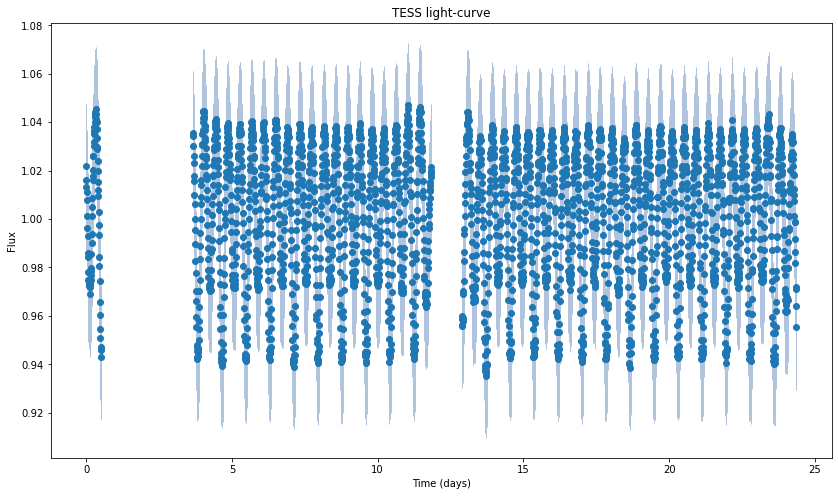


Computing periodogram ...



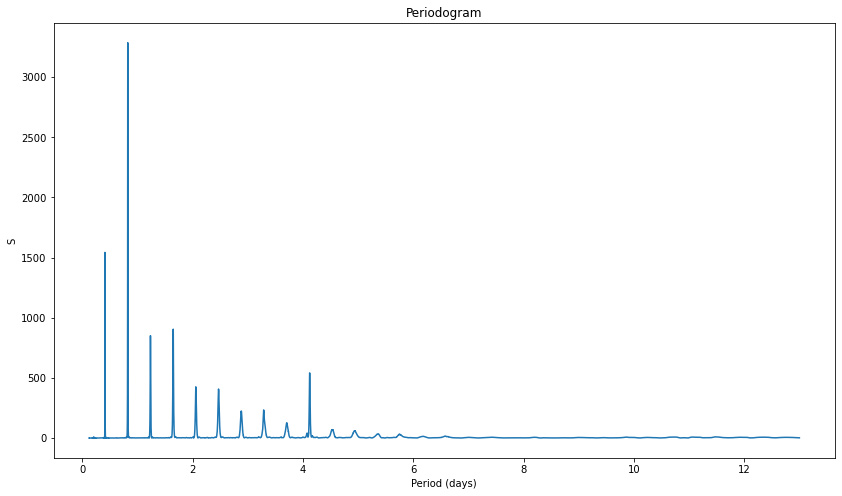

Found best period to be: 0.8237066235541185 days


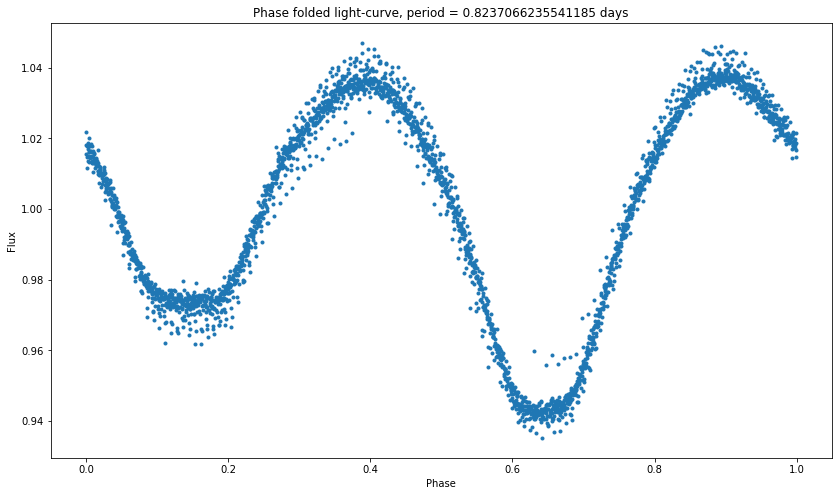

In [10]:
do_PDM("TIC-8170664_EA2_FLUX.dat", num_trial_periods=30000)

## RU Lep


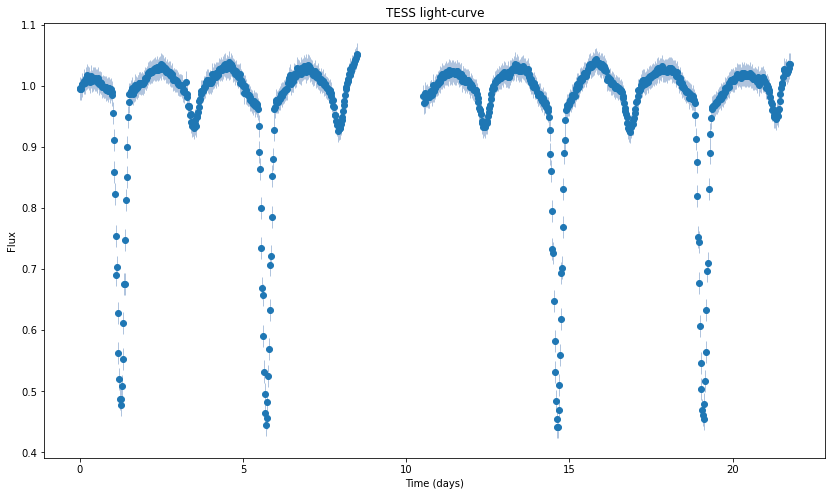


Computing periodogram ...



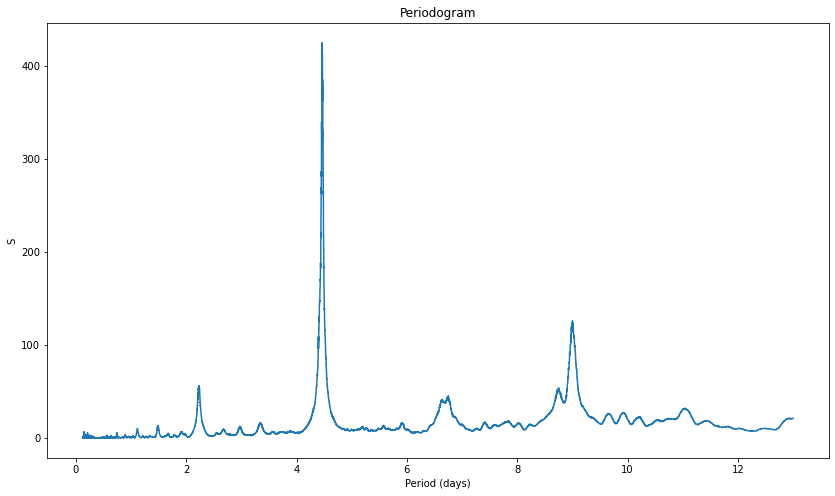

Found best period to be: 4.464877995933198 days


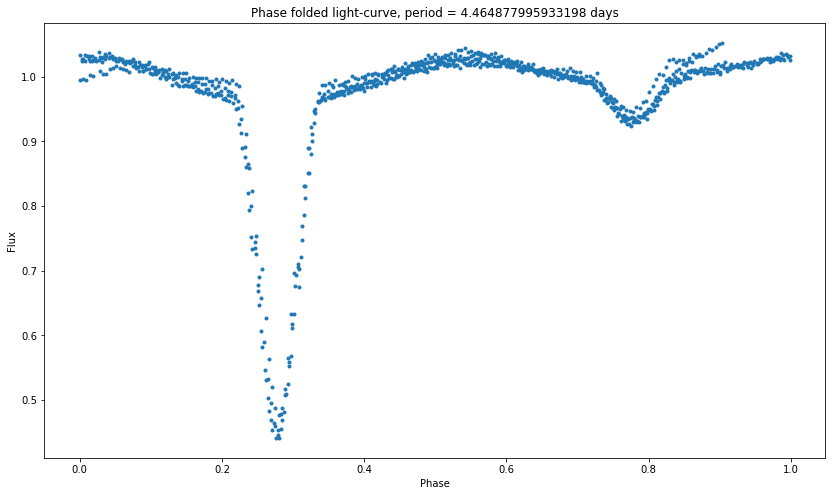

In [11]:
do_PDM("TIC-37157588_RU_lep_FLUX.dat", num_trial_periods=30000)

## TIC-61213992


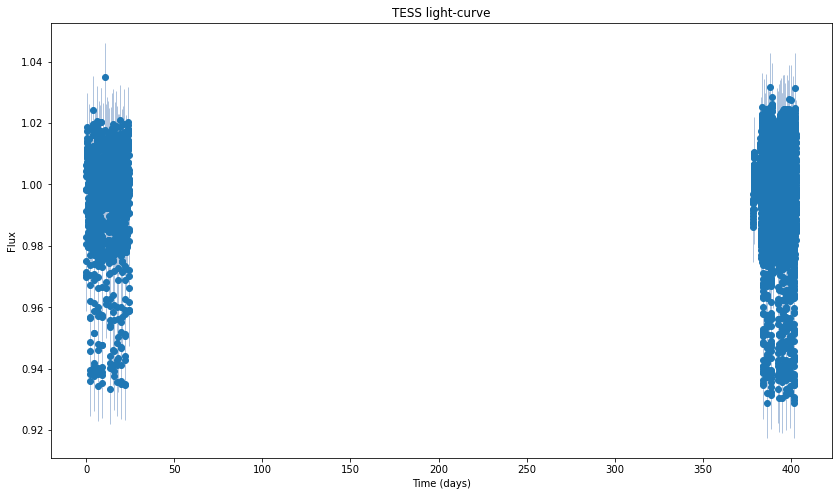


Computing periodogram ...



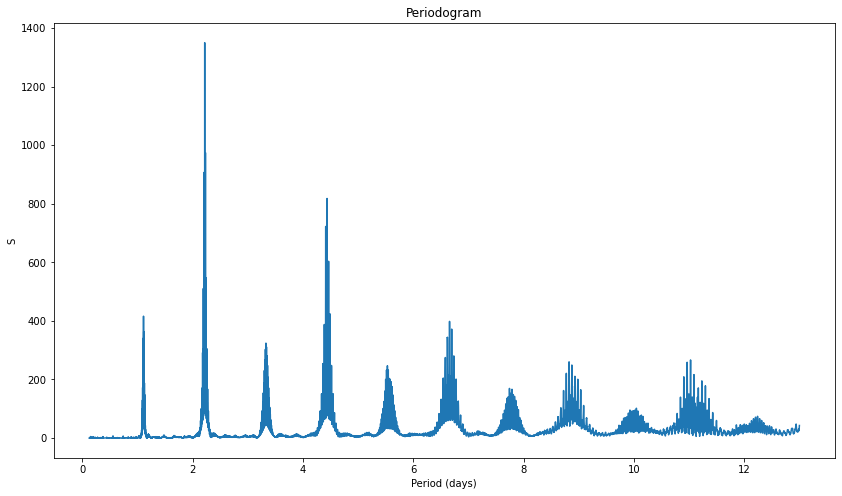

Found best period to be: 2.21897396579886 days


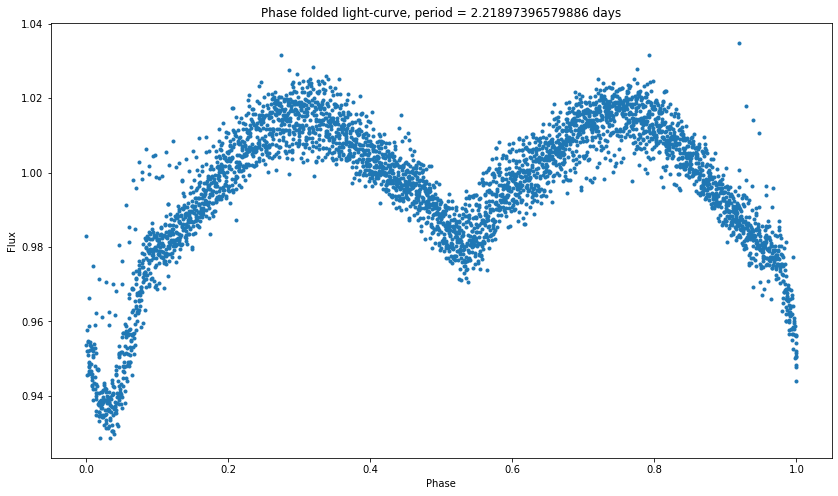

In [12]:
do_PDM(filename="TIC-61213992_EA2_FLUX.dat", num_trial_periods=30000)

## RV Crt


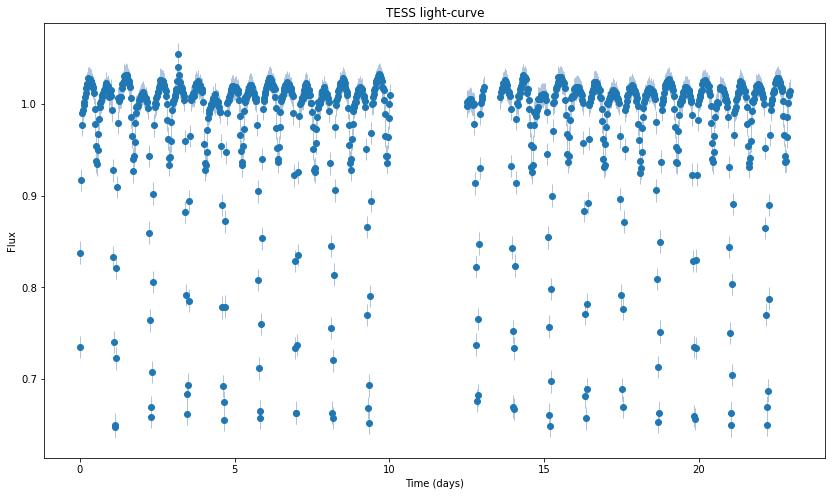


Computing periodogram ...



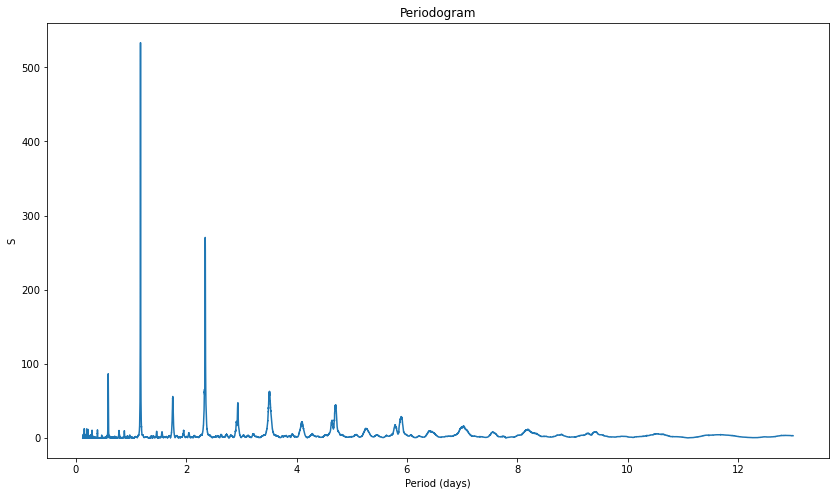

Found best period to be: 1.170484849494983 days


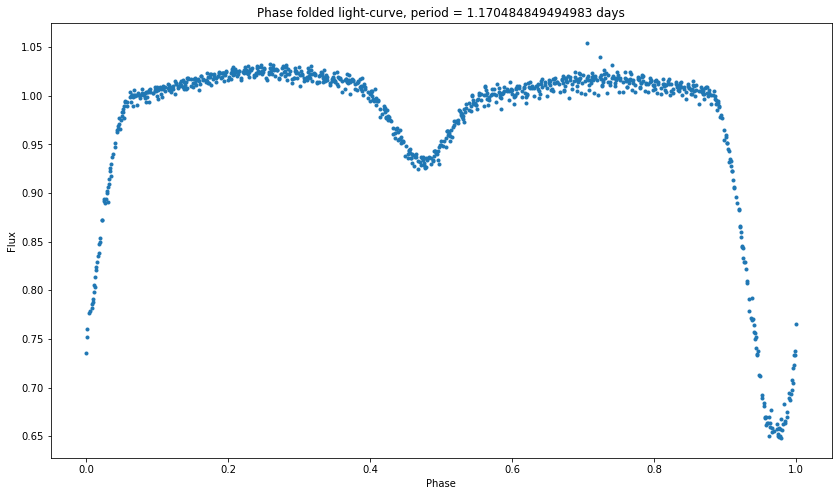

In [13]:
do_PDM(filename="TIC-437253391_RV_crt_FLUX.dat", num_trial_periods=30000)

## TIC-61332742


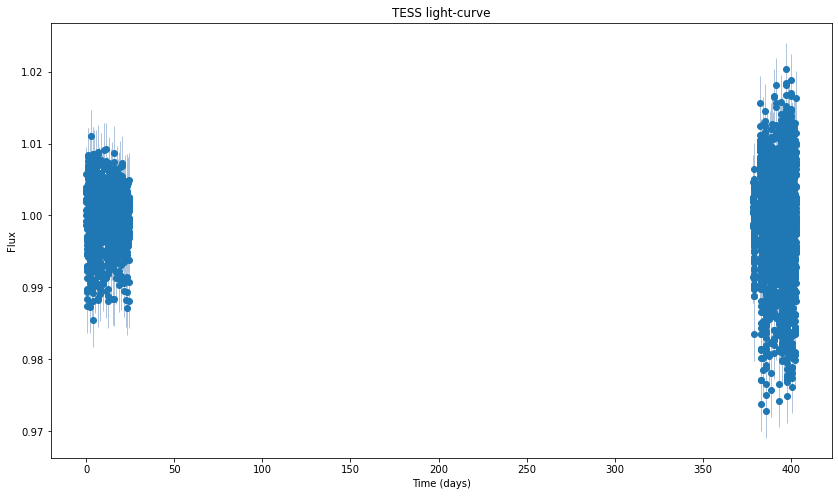


Computing periodogram ...



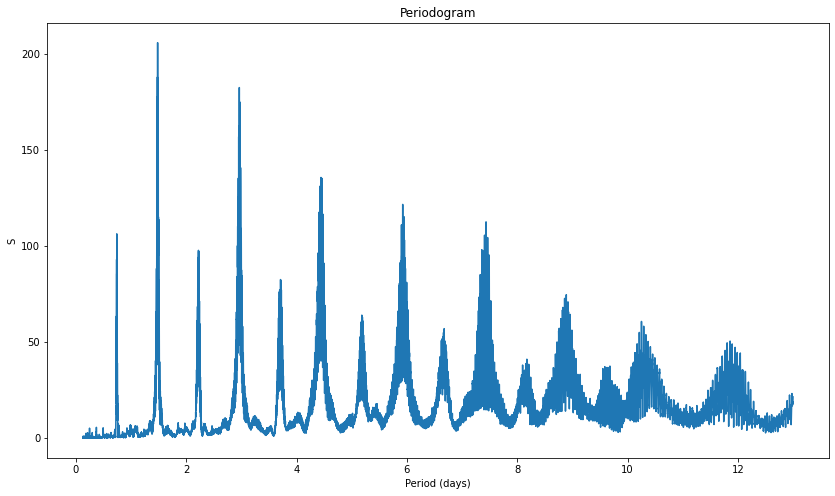

Found best period to be: 1.4807826927564252 days


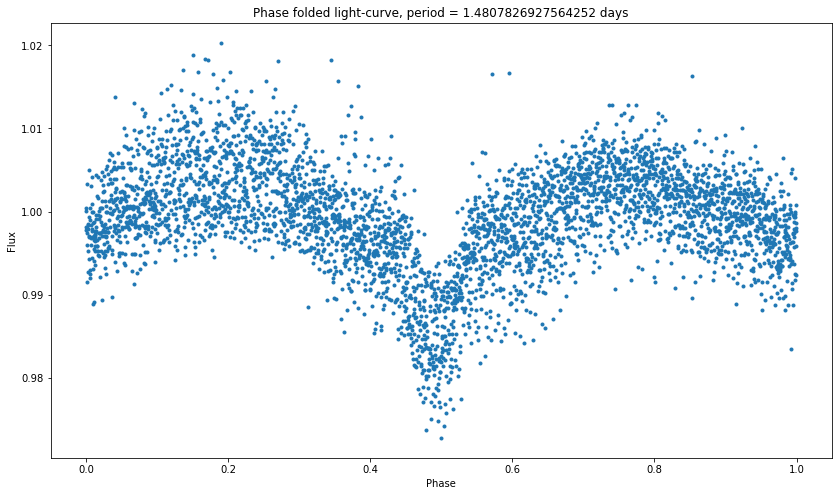

In [14]:
do_PDM(filename="TIC-61332742_Ellipsoidal_secondary_FLUX.dat", num_trial_periods=30000)

## WASP-5b


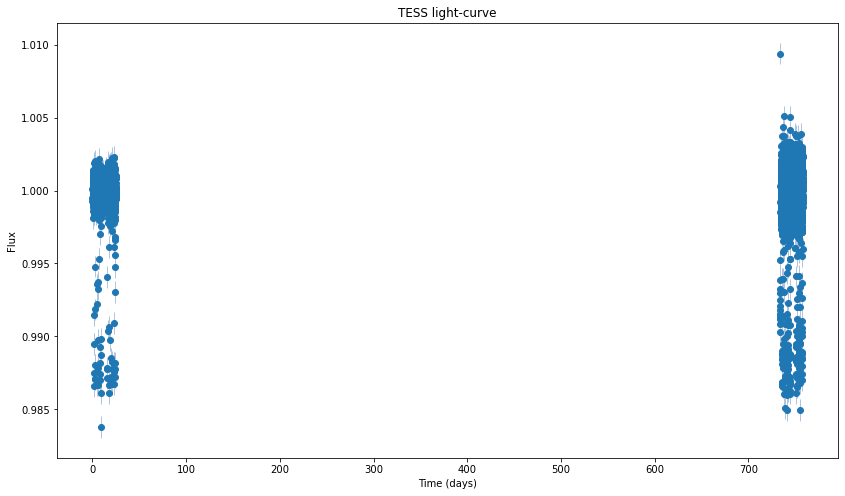


Computing periodogram ...



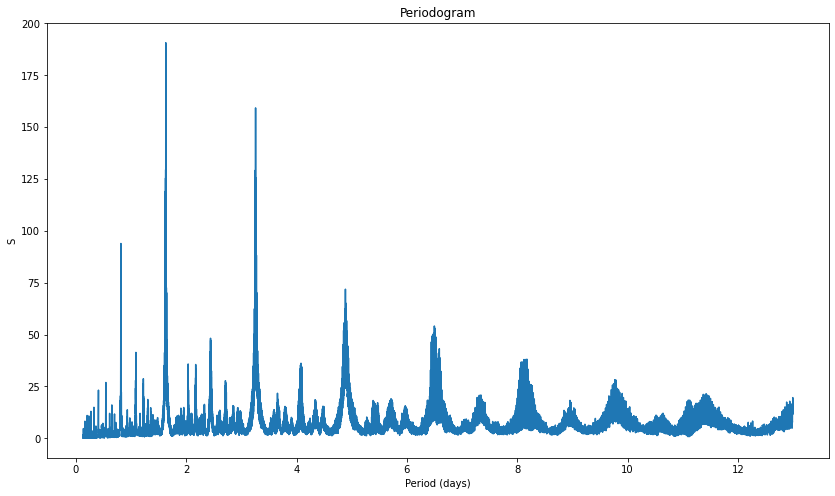

Found best period to be: 1.6284209473649123 days


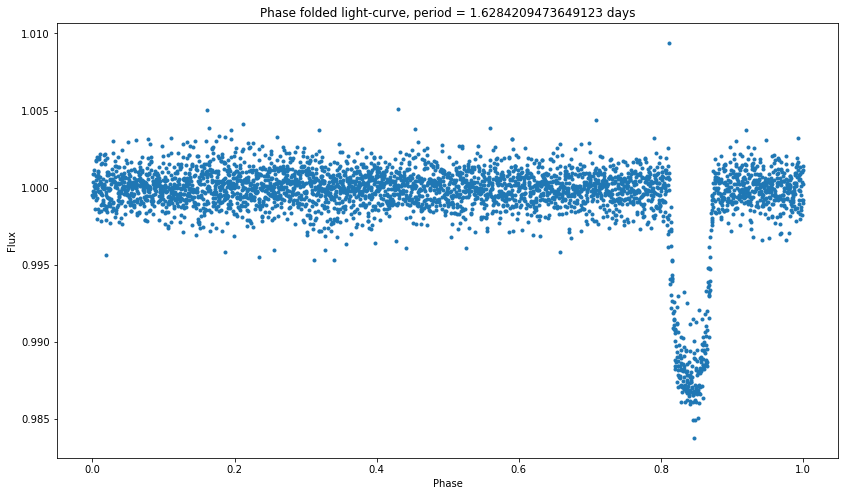

Percentage fractional difference between the found best period and the true period is: 0.00022430483350136608%


In [15]:
do_PDM(filename="WASP-5_TOI-250_FLUX.dat", num_trial_periods=30000, P_true=1.6284246)

## WASP-7b


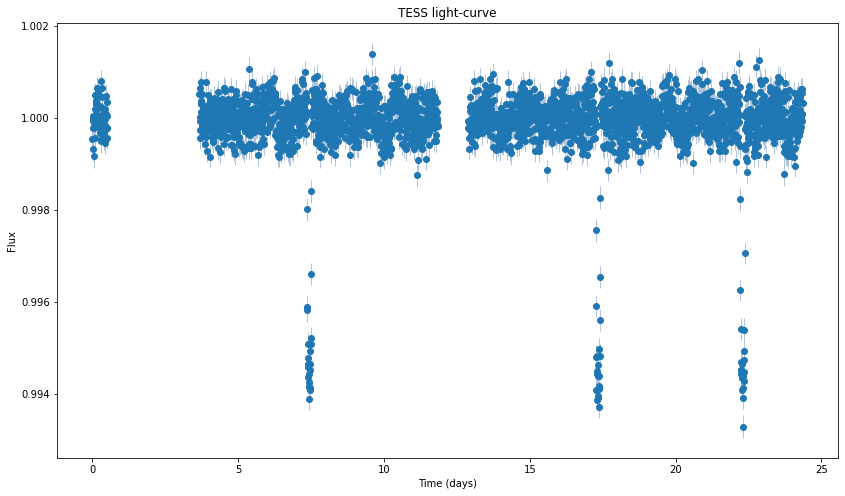


Computing periodogram ...



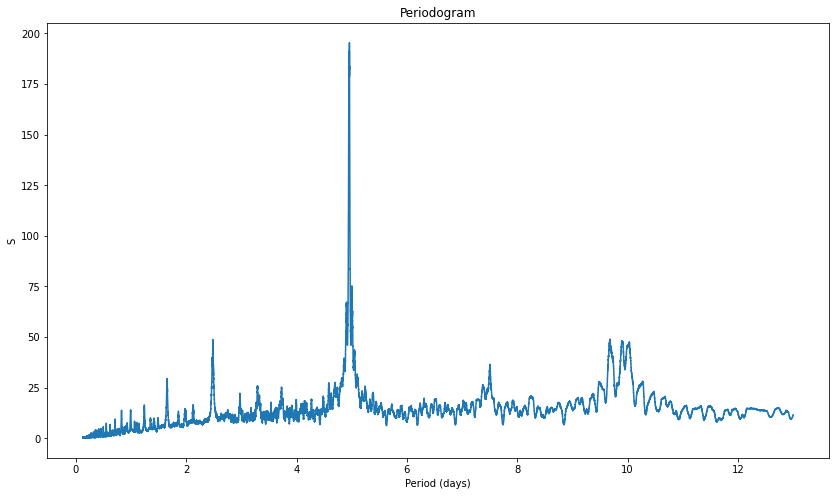

Found best period to be: 4.957926382106368 days


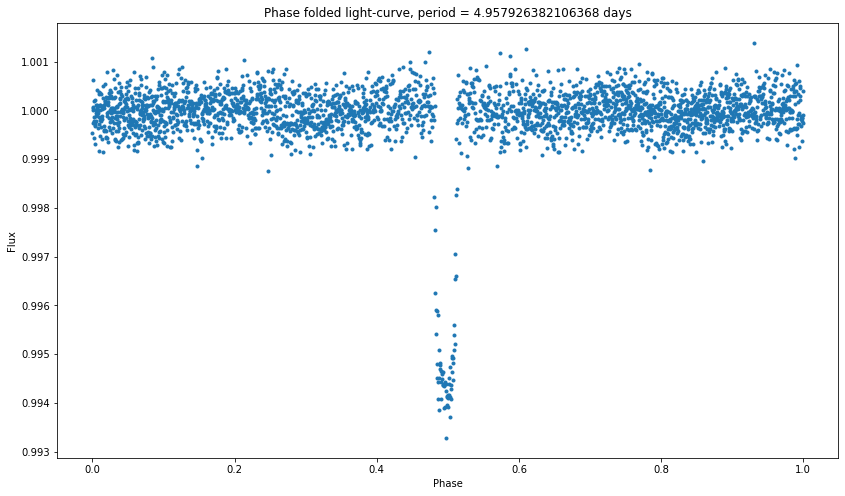

Percentage fractional difference between the found best period and the true period is: 0.06629706791239867%


In [16]:
do_PDM(
    filename="WASP-7_TOI-2197_FLUX.dat", M=25, num_trial_periods=60000, P_true=4.9546416
)

## WASP-31b


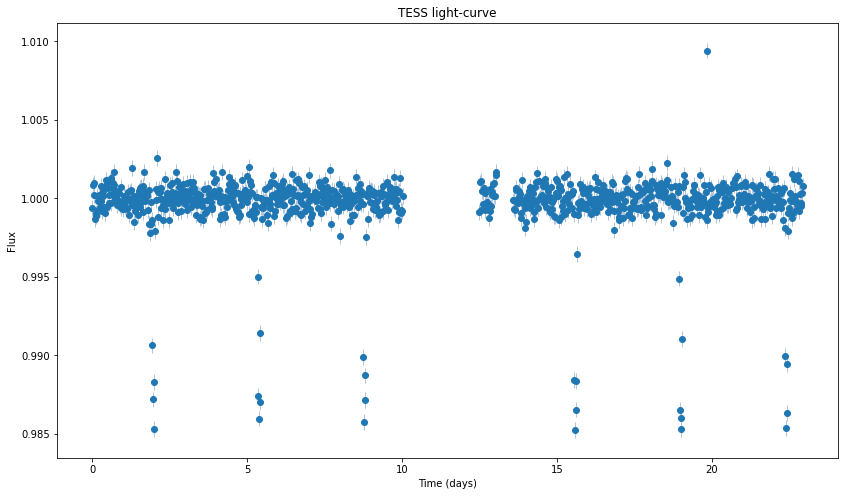


Computing periodogram ...



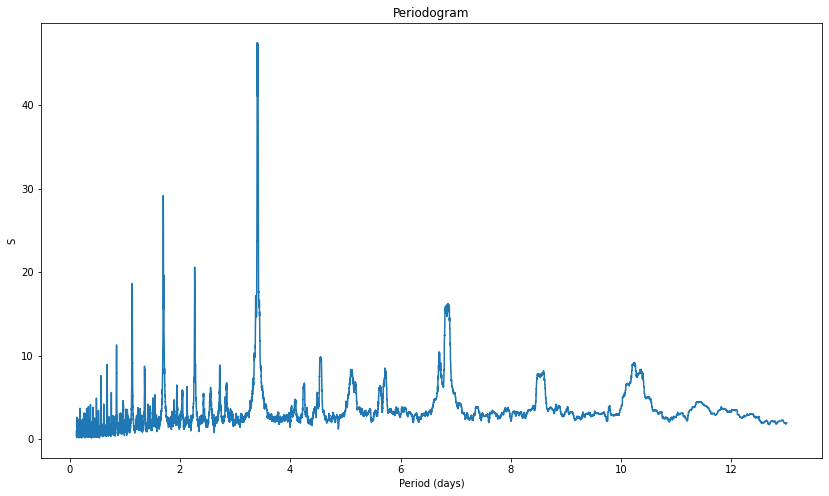

Found best period to be: 3.405659355311844 days


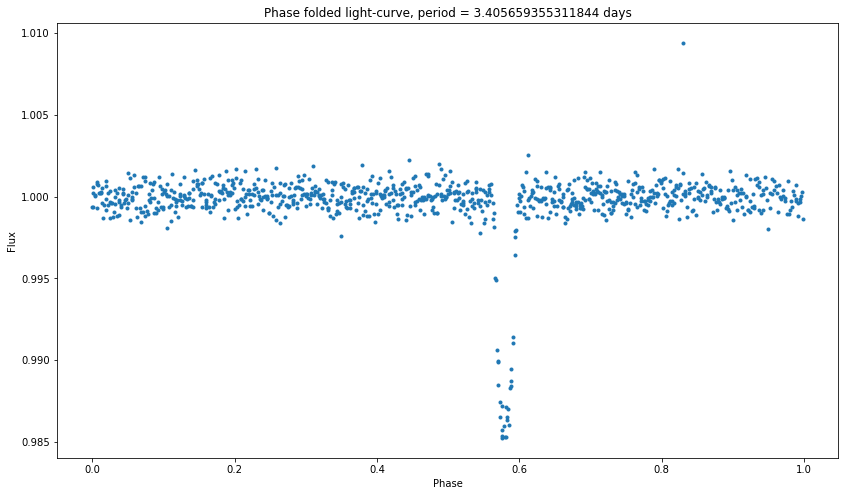

Percentage fractional difference between the found best period and the true period is: 0.007329752150040252%


In [17]:
do_PDM(filename="WASP-31_TOI-683_FLUX.dat", num_trial_periods=30000, P_true=3.405909)

## WASP-111b


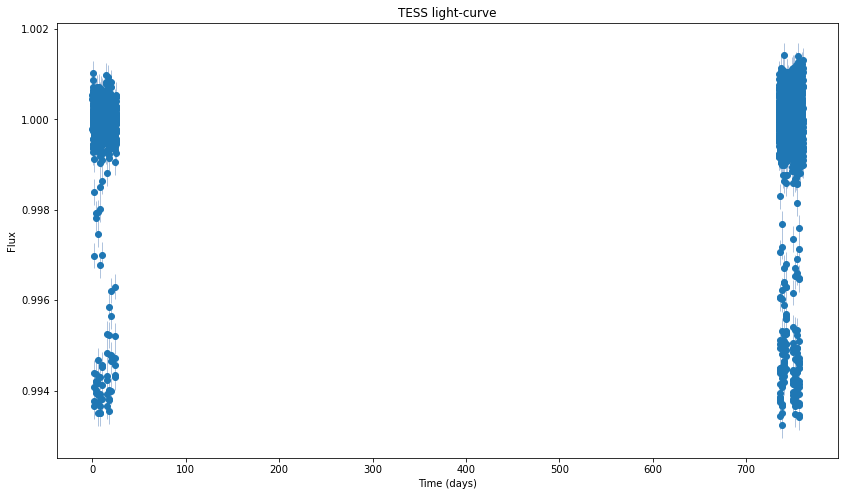


Computing periodogram ...



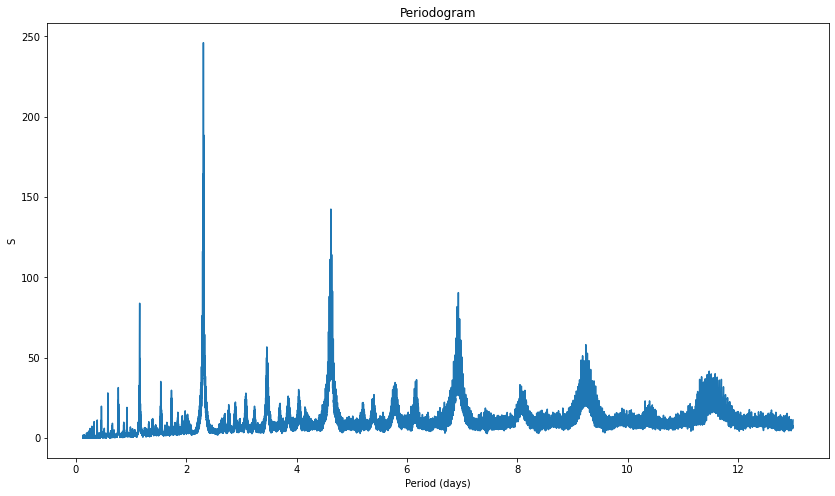

Found best period to be: 2.3108186939564654 days


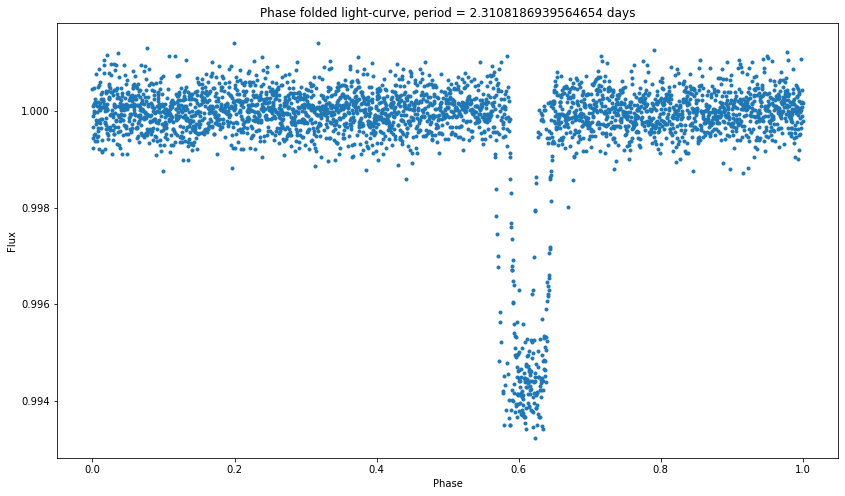

Percentage fractional difference between the found best period and the true period is: 0.006330950210604413%


In [18]:
do_PDM("WASP-111_TOI-143_FLUX.dat", M=29, num_trial_periods=30000, P_true=2.310965)

## WASP-112b


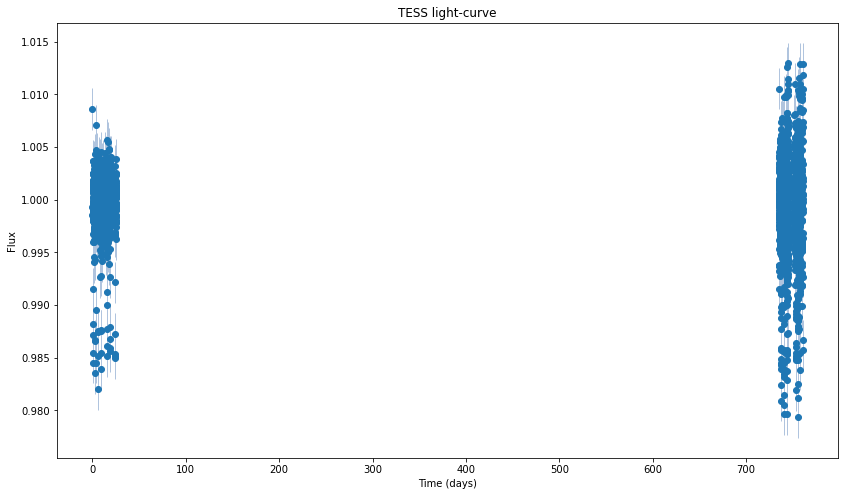


Computing periodogram ...



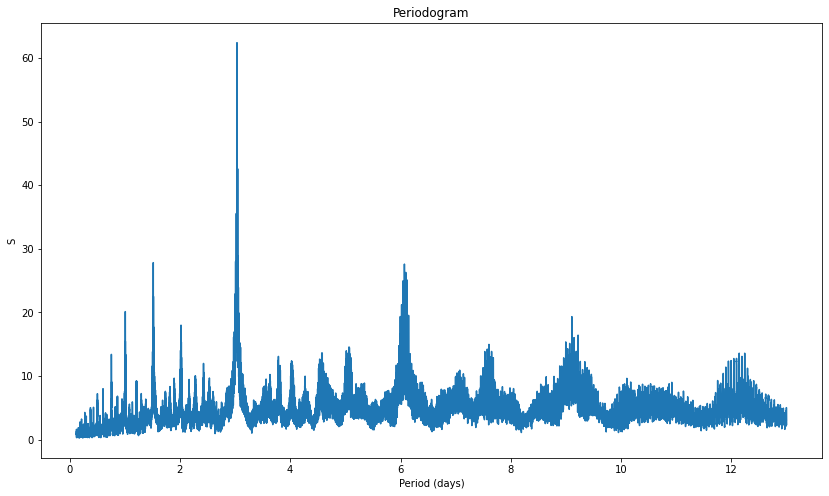

Found best period to be: 3.035276175872529 days


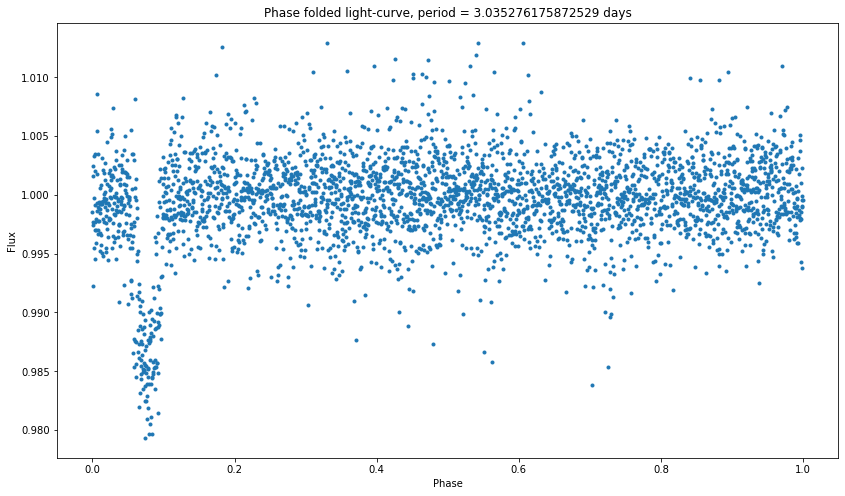

Percentage fractional difference between the found best period and the true period is: 0.004052980163894269%


In [19]:
do_PDM("WASP-112b_TOI-126_FLUX.dat", num_trial_periods=30000, P_true=3.0353992)